# Appendix A: Universal Function Approximation

In [248]:
import jax.numpy as np
import jax
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import ADAMLL as ada
from ADAMLL.activations import sigmoid, relu, eye

## Data
the `xor` function is a binary function that returns `1` if the inputs are different and `0` if the inputs are the same. The `xor` function is not linearly separable, so it cannot be represented by a single perceptron or simple logistic regression. However, it can be represented by a neural network with two layers. The first layer is a hidden layer with two nodes. The second layer is an output layer with one one. The following code defines the `xor` function and plots the data.
As we hinted at in the introduction, there may be a way for a single layer logistic regression model to represent the `xor` function, by fitting a polynomial to the data.

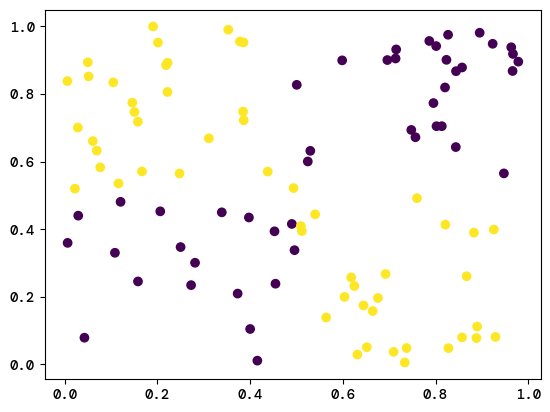

In [249]:
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key,(100,2))
t_xor = (x[:,0] >= 0.5) ^ (x[:,1] > 0.5)


plt.scatter(x[:,0],x[:,1],c=t_xor)
plt.show()


binary_xor = np.array([[0,0],[0,1],[1,0],[1,1]])
binary_target = np.array([0,1,1,0])

t_xor = t_xor.reshape(-1,1)
binary_target = binary_target.reshape(-1,1)

In [250]:
# plain logistic regression
model = ada.NN.Model([[1,sigmoid]])
model.fit(x, t_xor)


X = np.linspace(0,1,10)
Y = np.linspace(0,1,10)
X,Y = np.meshgrid(X,Y)

Z = model.predict(np.array([X.flatten(),Y.flatten()]).T).reshape(10,10)


Training stopped after 99 epochs                                      

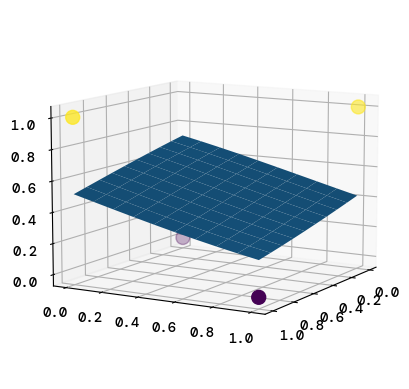

prediction: [1. 0. 1. 0.]
accuracy: 0.5


In [251]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(10, 30)
ax.scatter(binary_xor[:,0],binary_xor[:,1],binary_target, c=binary_target, s=100, cmap='viridis')
plt.show()
y = model.classify(binary_xor)
print("prediction: {}".format(y.ravel()))
print("accuracy: {}".format(ada.accuracy(y, binary_target)))






### Now we add a polynomial feature to the data and fit a logistic regression model to the data.

In [252]:
# transform data to polynomial
poly = PolynomialFeatures(3)
x = poly.fit_transform(x)

In [253]:
# plain logistic regression
model = ada.NN.Model([[1,sigmoid]], epochs=100, eta=0.1,optimizer="adam", loss=ada.CE)
model.fit(x, t_xor) 


XY = np.array([X.flatten(),Y.flatten()]).T
XY = poly.fit_transform(XY)
Z = model.predict(XY).reshape(10,10)

Training stopped after 99 epochs                                      

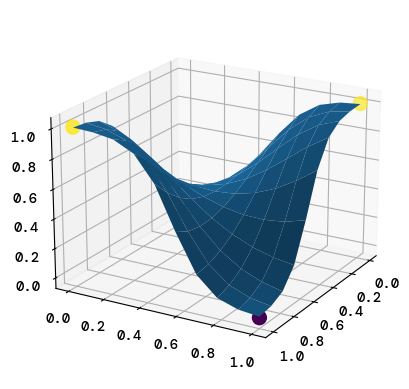

prediction: [0. 1. 1. 0.]
accuracy: 1.0


In [254]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(20, 30)
ax.scatter(binary_xor[:,0],binary_xor[:,1],binary_target, c=binary_target, s=100)
plt.show()
y = model.classify(poly.transform(binary_xor))
print("prediction: {}".format(y.ravel()))
print("accuracy: {}".format(ada.accuracy(y, binary_target)))

# Neural networks
NNs can also learn xor, without the need for a polynomial feature. This is important because it is not always obvious what feature engineering is required to solve a problem. Neural networks can learn the relevant features from the data. Manually adding polynomial features is not a scalable solution for high-dimensional data, whereas neural networks can learn arbitrarily complex functions. Adding polynomial featurer is also prone to bias problems.

In [255]:
x = jax.random.uniform(key,(100,2)) # reset x

In [256]:
model = ada.NN.Model([[4, sigmoid],[1, sigmoid]], epochs=100, eta=0.1,optimizer="adam", loss=ada.CE)
model.fit(x, t_xor) 


XY = np.array([X.flatten(),Y.flatten()]).T
Z = model.predict(XY).reshape(10,10)

Training stopped after 99 epochs                                      

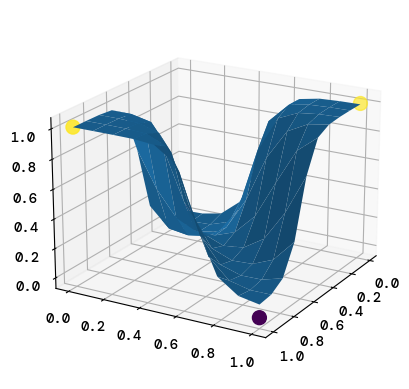

prediction: [0. 1. 1. 0.]
accuracy: 1.0


In [257]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(20, 30)
ax.scatter(binary_xor[:,0],binary_xor[:,1],binary_target, c=binary_target, s=100)
plt.show()
y = model.classify(binary_xor)
print("prediction: {}".format(y.ravel()))
print("accuracy: {}".format(ada.accuracy(y, binary_target.reshape(-1,1))))

## NNs can learn any* function by combining multiple perceptrons

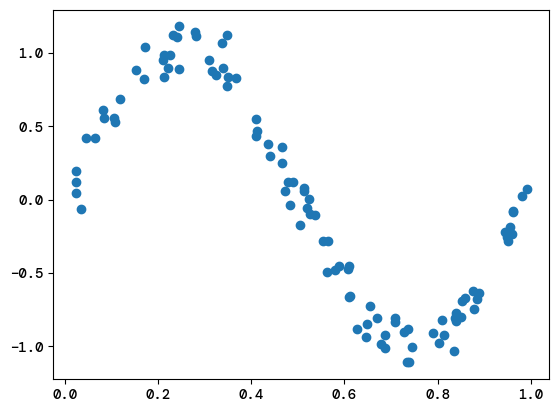

In [258]:
x = np.linspace(0,1,100)
def f(x):
    # return -20*(0.5-x)**2
    return np.sin(2*np.pi*x)





x = jax.random.uniform(key,(100,1))
key, subkey = jax.random.split(key)
t = f(x) + jax.random.normal(subkey,(100,1))*0.1

x.reshape(-1,1)
t.reshape(-1,1)
plt.scatter(x,t)
plt.show()

In [259]:
model = ada.NN.Model([[4,sigmoid],[1,eye]], epochs=300, eta=0.1, optimizer="adam", loss=ada.MSE, metric=ada.MSE,alpha=0.0001)
loss, params = model.fit(x, t )

Training stopped after 299 epochs                                     

<Figure size 640x480 with 0 Axes>

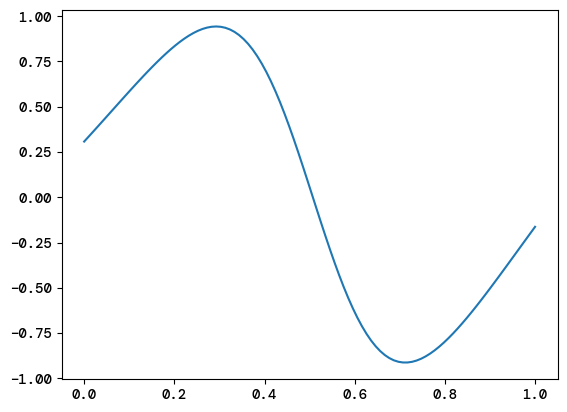

<Figure size 640x480 with 0 Axes>

In [260]:
x = np.linspace(0,1,100).reshape(-1,1)
y = model.predict(x)
plt.plot(x,y) 
plt.figure()


#### The induvidual nodes in the first layer becomes the following:

[[ 2.4847994 10.605754  -2.0016232  2.546264 ]]


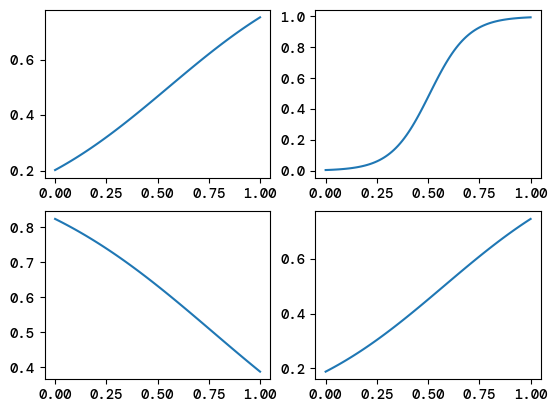

In [261]:
fig, ax = plt.subplots(2,2)
nodes = sigmoid(x @ params[0]["w"] + params[0]["b"])
print(params[0]["w"])
ax[0,0].plot(x,nodes[:,0])
ax[0,1].plot(x,nodes[:,1])
ax[1,0].plot(x,nodes[:,2])
ax[1,1].plot(x,nodes[:,3])
plt.show()

you can view these as individual logistic regression models.

#### The output then becomes a affine transformation of the first layer:

$\text{out} = \sum_{i=1}^n w_i \: \text{node}_i\: + b$

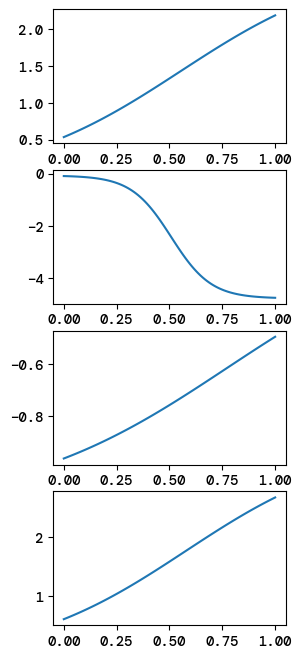

In [262]:
fig, ax = plt.subplots(4,1, figsize=(3,8))
out1 = ( nodes[:,0] * params[1]["w"][0] + params[1]["b"][0] )
out2 = ( nodes[:,1] * params[1]["w"][1] + params[1]["b"][1] )
out3 = ( nodes[:,2] * params[1]["w"][2] + params[1]["b"][2] )
out4 = ( nodes[:,3] * params[1]["w"][3] + params[1]["b"][3] ) 
ax[0].plot(x,out1)
ax[1].plot(x,out2)
ax[2].plot(x,out3)
ax[3].plot(x,out4)
plt.show()


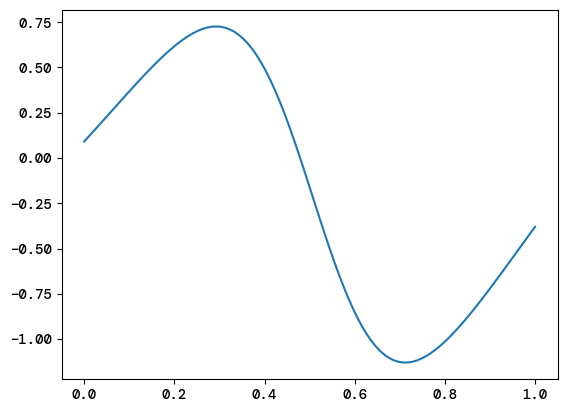

In [263]:
fig, ax = plt.subplots()
ax.plot(x,out1+out2+out3+out4)

We can chose whatever activation function we want as long as it is non-linear. Relu strugles to learn this sin function, but sigmoid works fine.